In [1]:

import time
from collections import deque, namedtuple

import gym
import numpy as np
import PIL.Image
import tensorflow as tf
import utils
import pyautogui
import cv2
import platform
import pkg_resources

from pyvirtualdisplay import Display
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.losses import MSE
from tensorflow.keras.optimizers import Adam

C:\Users\RAMON MARIA TENREIRO\AppData\Local\Programs\Python\Python311\Lib\site-packages\tensorflow\python\debug\cli\debugger_cli_common.py:19: DeprecationWarning: module 'sre_constants' is deprecated
  import sre_constants
C:\Users\RAMON MARIA TENREIRO\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\engine\data_adapter.py:44: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [2]:
import gym

# Crea el entorno del  Lunar Lander environment
env = gym.make('LunarLander-v2')

In [3]:
# Configurar una pantalla virtual
pyautogui.FAILSAFE = False 
screen_width, screen_height = pyautogui.size()
virtual_display = (screen_width, screen_height)

# Establecer semilla aleatoria para TensorFlow
tf.random.set_seed(utils.SEED)

In [4]:
MEMORY_SIZE = 100_000     # Tamaño memoria buffer
GAMMA = 0.995             # factor decuento
ALPHA = 1e-3              # factor aprendizaje  
NUM_STEPS_FOR_UPDATE = 4  # realizar una actualización de aprendizaje cada C pasos de tiempo

<a name="3"></a>
 El entorno del módulo de aterrizaje lunar

En este cuaderno usaremos [OpenAI's Gym Library](https://www.gymlibrary.dev/). La librería Gym Proporciona una amplia variedad de entornos para el aprendizaje por refuerzo. En pocas palabras, un entorno representa un problema o tarea por resolver. En este cuaderno, intentaremos resolver el entorno del Lunar Lander mediante el aprendizaje por refuerzo.

El objetivo del entorno Lunar Lander es hacer aterrizar el módulo lunar de forma segura en la superficie de la luna. La plataforma de aterrizaje está señalada con dos banderines y su centro está en las coordenadas '(0,0)', pero el módulo lunar también puede aterrizar fuera de la plataforma de aterrizaje. El módulo lunar comienza en el centro superior del entorno con una fuerza inicial aleatoria aplicada a su centro de masa y tiene combustible infinito. El entorno se considera resuelto si obtienes '200' puntos.

<br>
<br>
<figure>
  <img src = "images/lunar_lander.gif" width = 40%>
      <figcaption style = "text-align: center; font-style: italic">Fig 1. Lunar Lander Environment.</figcaption>
</figure>



<a name="3.1"></a>
Acción espacial

El agente tiene cuatro acciones discretas disponibles:

* Nada.
* Usar motor derecho.
* Usar motor principal.
* Usar motor izquierdo.

Cada acción tiene un valor numérico correspondiente:

```python
Do nothing = 0
Fire right engine = 1
Fire main engine = 2
Fire left engine = 3
```

<a name="3.2"></a>
Observación espacial

El espacio de observación del agente consta de un vector de estado con 8 variables:

* Sus coordenadas $(x,y)$. La plataforma de aterrizaje siempre está en las coordenadas $(0,0)$.
* Sus velocidades lineales $(\dot x,\dot y)$.
* Su ángulo $\theta$.
* Su velocidad angular $\dot \theta$.
* Dos booleanos, $l$ y $r$, que representan si cada pata está en contacto con el suelo o no.
<a name="3.3"></a>
Recompensas

Después de cada acción, se otorga una recompensa. La recompensa total de un episodio es la suma de las recompensas de todos los pasos de ese episodio.

Por cada paso, la recompensa:
- aumenta/disminuye cuanto más cerca/más lejos esté el módulo de aterrizaje de la plataforma de aterrizaje.
- aumenta/disminuye cuanto más lento/más rápido se mueve el módulo de aterrizaje.
- disminuye cuanto más se inclina el módulo de aterrizaje (ángulo no horizontal).
- Se incrementa en 10 puntos por cada pierna que esté en contacto con el suelo.
- se reduce en 0,03 puntos por cada vez que se enciende un motor lateral.
- se reduce en 0,3 puntos por cada vez que se enciende el motor principal.

El episodio recibe una recompensa adicional de -100 o +100 puntos por estrellarse o aterrizar de forma segura, respectivamente
<a name="3.4"></a>
Finalización del episodio

Un episodio termina (es decir, el entorno entra en el estado final) si:

* El módulo de aterrizaje lunar se estrella (es decir, si el cuerpo del módulo de aterrizaje lunar entra en contacto con la superficie de la luna).

* El valor absoluto de la coordenada $x$ del módulo de aterrizaje es mayor que 1 (es decir, va más allá del borde izquierdo o derecho)

Puedes consultar el [Open AI Gym documentation](https://www.gymlibrary.dev/environments/box2d/lunar_lander/) para una descripción completa del entorno.

<a name="4"></a>
##  Cargar el entorno

Se carga el entorno del `LunarLander-v2` desde la librería `gym` usando el método `.make()` method. `LunarLander-v2` es la última versión del entorno Lunar Lander y puedes descubir su historia [Open AI Gym documentation](https://www.gymlibrary.dev/environments/box2d/lunar_lander/#version-history).

In [5]:
env = gym.make('LunarLander-v2')

Una vez que cargamos el entorno, utilizamos el método `.reset()` para restablecer el entorno al estado inicial. El módulo de aterrizaje comienza en la parte superior central del entorno y podemos renderizar el primer fotograma del entorno utilizando el método `.render()`.

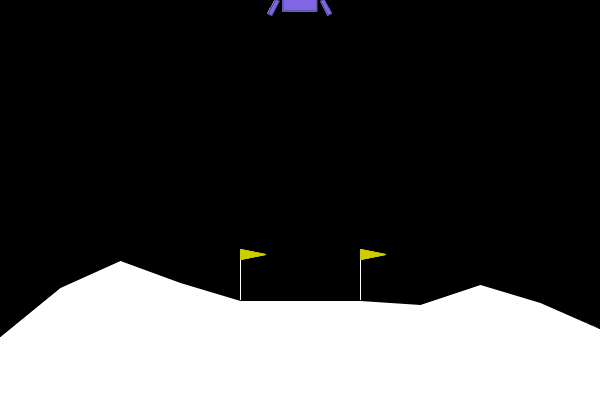

In [6]:
env.reset()

#matriz de imagen = env.render()

PIL.Image.fromarray(env.render(mode='rgb_array'))

Para construir nuestra red neuronal más adelante, necesitamos saber el tamaño del vector de estado y el número de acciones válidas. Podemos obtener esta información de nuestro entorno utilizando los métodos `.observation_space.shape` y `action_space.n`, respectivamente.

In [7]:
state_size = env.observation_space.shape
num_actions = env.action_space.n

print('Forma de estado:', state_size)
print('Número de acciones:', num_actions)

Forma de estado: (8,)
Número de acciones: 4


<a name="5"></a>
## Interactuar con la librería Gym

La librería Gym implementa el formalismo estándar de "bucle agente-entorno":

<br>
<center>
<video src = "./videos/rl_formalism.m4v" width="840" height="480" controls autoplay loop poster="./images/rl_formalism.png"> </video>
<figcaption style = "text-align:center; font-style:italic">Fig 2. Agent-environment Loop Formalism.</figcaption>
</center>
<br>

En el formalismo estándar del “bucle agente-entorno”, un agente interactúa con el entorno en pasos de tiempo discretos $t=0,1,2,...$. En cada paso de tiempo $t$, el agente utiliza una política $\pi$ para seleccionar una acción $A_t$ en función de su observación del estado del entorno $S_t$. El agente recibe una recompensa numérica $R_t$ y en el siguiente paso de tiempo, pasa a un nuevo estado $S_{t+1}$.

<a name="5.1"></a>
### Explorando la dinámica del medio ambiente

Para abrir los entornos de Open AI's Gym, utilizamos el método `.step()` para ejecutar un único paso de tiempo de la dinámica del entorno. En la version de `gym` que utilizamos el método `.step()` acepta una acción y devuelve cuatro valores:

* `observación` (**object**): un objeto específico del entorno que representa su observación del entorno. En el entorno del módulo de aterrizaje lunar, esto corresponde a una matriz que contiene las posiciones y velocidades del módulo de aterrizaje como se describe en la sección [3.2 Observation Space](#3.2).


* `recompensa` (**float**): cantidad de recompensa devuelta como resultado de realizar la acción determinada. En el entorno de Lunar Lander, esto corresponde con una cifra de tipo `numpy.float64` como se describe en la sección [3.3 Rewards](#3.3).


* `hecho` (**boolean**): Cuando esta terminado `True`, indica que el episodio ha terminado y es hora de restablecer el entorno. 


* `info` (**dictionary**): Información de diagnóstico útil para la depuración. No usaremos esta variable en este cuaderno, pero se muestra aquí para que esté completa la información.

Para comenzar un episodio, necesitamos restablecer el entorno a un estado inicial. Hacemos esto usando el método `.reset()`. 

In [8]:
# Restablecer el entorno y coger el estado inicial.
current_state = env.reset()

Una vez que se restablece el entorno, el agente puede comenzar a realizar acciones en el entorno utilizando el método 'step()' Tenga en cuenta que el agente sólo puede realizar una acción por cada paso de tiempo.

En la celda siguiente puede seleccionar diferentes acciones y ver cómo los valores devueltos cambian según la acción realizada. Recuerde que en este entorno el agente tiene cuatro acciones discretas disponibles y las especificamos en código utilizando su correspondiente valor numérico:

```python
Do nothing = 0
Fire right engine = 1
Fire main engine = 2
Fire left engine = 3
```

In [9]:
# Seleccionar una acción
action = 0

# Ejecutar un único paso de tiempo de la dinámica del entorno con la acción dada.
step_result = env.step(action)

# Verificar la cantidad de valores devueltos y manejar en consecuencia
if len(step_result) >= 4:
    # Desempaquetar los valores del resultado del paso.
    next_state, reward, done, _ = step_result[:4]
else:
    # Manejar la situación cuando el número de valores es diferente
    print(f"Unexpected number of values returned by env.step(): {len(step_result)}")

# Mostrar tabla con valores.
utils.display_table(current_state, action, next_state, reward, done)



E:\COURSERA\LIBRO\MachineLearningInteligenciaArtificial\3.4.1_RL_LunaLander\utils.py:345: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  (STATE_VECTOR_COL_NAME, 'Ground contact', 'Left Leg?'): get_state(6, np.bool),
E:\COURSERA\LIBRO\MachineLearningInteligenciaArtificial\3.4.1_RL_LunaLander\utils.py:354: FutureWarning: Styler.applymap has been deprecated. Use Styler.map instead.
  .applymap(lambda x: 'background-color : grey' if x == '' else '')\


En la práctica, cuando entrenamos al agente utilizamos un bucle para permitirle realizar muchas acciones consecutivas durante un episodio.

<a name="6"></a>
## Deep Q-Learning

En los casos en los que tanto el estado como el espacio de acción son discretos, podemos estimar la función de valor de acción de forma iterativa utilizando la ecuación de Bellman:
$$
Q_{i+1}(s,a) = R + \gamma \max_{a'}Q_i(s',a')
$$

Este método iterativo converge a la función de valor de acción óptima $Q^*(s,a)$ as $i\to\infty$. Esto significa que el agente solo necesita explorar gradualmente el espacio estado-acción y seguir actualizando la estimación de $Q(s,a)$ uhasta que converja a la función óptima de valor de acción $Q^*(s,a)$. Sin embargo, en los casos en que el espacio de estados es continuo, resulta prácticamente imposible explorar todo el espacio de acción de estados. En consecuencia, esto también hace que sea prácticamente imposible estimar gradualmente $Q(s,a)$ hasta que converja a $Q^*(s,a)$.

En Deep $Q$-Learning, resolvemos este problema utilizando una red neuronal para estimar la función de valor de acción $Q(s,a)\approx Q^*(s,a)$. A esta red neuronal la llamamos red $Q$-Network y se puede entrenar ajustando sus pesos en cada iteración para minimizar el error cuadrático medio en la ecuación de Bellman.

Desafortunadamente, el uso de redes neuronales en el aprendizaje por refuerzo para estimar funciones de valor de acción ha demostrado ser muy inestable. Afortunadamente, existen un par de técnicas que se pueden emplear para evitar inestabilidades. Estas técnicas consisten en utilizar una ***Red de destino*** y una ***Repetición de experiencia***. Exploraremos estas dos técnicas en las siguientes secciones.

<a name="6.1"></a>
### Red objetivo

Podemos entrenar la red $Q$-Network ajustando sus pesos en cada iteración para minimizar el error cuadrático medio en la ecuación de Bellman, donde los valores objetivo vienen dados por:

$$
y = R + \gamma \max_{a'}Q(s',a';w)
$$

donde $w$ son los pesoso de la red $Q$-Network. Esto significa que estamos ajustando los pesos $w$ en cada iteración para minimizar el siguiente error:

$$
\overbrace{\underbrace{R + \gamma \max_{a'}Q(s',a'; w)}_{\rm {y~target}} - Q(s,a;w)}^{\rm {Error}}
$$

Tenga en cuenta que esto constituye un problema porque el objetivo $y$ cambia en cada iteración. Tener un objetivo en constante movimiento puede provocar oscilaciones e inestabilidades. Para evitar esto, podemos crear
una red neuronal separada para generar los objetivos $y$. A esta red neuronal separada la llamamos **target $\hat Q$-Network** y tendrá la misma arquitectura que la original $Q$-Network. Al utilizar la red objetivo $\hat Q$-Network, el error anterior se convierte en:

$$
\overbrace{\underbrace{R + \gamma \max_{a'}\hat{Q}(s',a'; w^-)}_{\rm {y~target}} - Q(s,a;w)}^{\rm {Error}}
$$

donde $w^-$ y $w$ son los pesos de la red $\hat Q$-Network y $Q$-Network, respectivamente.

En la práctica, usaremos el siguiente algoritmo: cada paso de tiempo $C$ usaremos la red $\hat Q$-Network para generar los objetivos $y$ y actualizar los pesos de la red $\hat Q$-Network. Actualizaremos los pesos $w^-$ de la red objetivo $\hat Q$-Network mediante una **actualización suave**. Esto significa que actualizaremos los pesos $w^-$ usando la siguiente regla:
 
$$
w^-\leftarrow \tau w + (1 - \tau) w^-
$$

Donde $\tau\ll 1$. Al utilizar la actualización suave, nos aseguramos de que los valores objetivo, $y$, cambien lentamente, lo que mejora en gran medida la estabilidad de nuestro algoritmo de aprendizaje.

<a name="ex01"></a>
### RED NEURONAL


creamos la 𝑄
   y apunta a 𝑄̂
   redes y configurar el optimizador. Recuerda que la 𝑄 Profunda
  -Network (DQN) es una red neuronal que aproxima la función acción-valor 𝑄(𝑠,𝑎)≈𝑄∗(𝑠,𝑎)
  . Para ello, aprende a asignar estados a 𝑄
   valores.

Para resolver el entorno Lunar Lander, emplearemos un DQN con la siguiente arquitectura:

Una capa de entrada que toma state_size como entrada.

Una capa densa con 64 unidades y una función de activación relu.

Una capa densa con 64 unidades y una función de activación relu.

Una capa densa con unidades num_actions y una función de activación lineal. Esta será la capa de salida de nuestra red.

En la celda de abajo debes crear la 𝑄
  -La red y el objetivo 𝑄̂
  -Red utilizando la arquitectura modelo descrita anteriormente. Recuerda que tanto la 𝑄
  -La red y el objetivo 𝑄̂
  -La red tiene la misma arquitectura.

Por último, debes configurar a Adam como optimizador con una tasa de aprendizaje igual a ALPHA. Recuerde que ALPHA se definió en la sección Hiperparámetros. Debemos tener en cuenta que para este ejercicio debes utilizar los paquetes ya importados:

To solve the Lunar Lander environment, we are going to employ a DQN with the following architecture:

* An `Input` layer that takes `state_size` as input.

* A `Dense` layer with `64` units and a `relu` activation function.

* A `Dense` layer with `64` units and a `relu` activation function.

* A `Dense` layer with `num_actions` units and a `linear` activation function. This will be the output layer of our network.


In the cell below you should create the $Q$-Network and the target $\hat Q$-Network using the model architecture described above. Remember that both the $Q$-Network and the target $\hat Q$-Network have the same architecture.

Lastly, you should set `Adam` as the optimizer with a learning rate equal to `ALPHA`. Recall that `ALPHA` was defined in the [Hyperparameters](#2) section. We should note that for this exercise you should use the already imported packages:
```python
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.optimizers import Adam
```

In [10]:
# Create the Q-Network
q_network = Sequential([
    Input(shape=state_size),
    Dense(64, activation='relu'),
    Dense(64, activation='relu'),
    Dense(num_actions, activation='linear')
    ])

# Create the target Q^-Network
target_q_network = Sequential([
    Input(shape=state_size),
    Dense(64, activation='relu'),
    Dense(64, activation='relu'),
    Dense(num_actions, activation='linear')
    ])

optimizer = Adam(learning_rate=ALPHA)


In [11]:
# Guardar la experiencia
experience = namedtuple("Experience", field_names=["state", "action", "reward", "next_state", "done"])

In [12]:
# Funcion Claculo de la pérdida
def compute_loss(experiences, gamma, q_network, target_q_network):
    """ 
    Calculo de la función de pérdida
    
    Args:
      experiences: (tuple) tuple of ["state", "action", "reward", "next_state", "done"] namedtuples
      gamma: (float) The discount factor.
      q_network: (tf.keras.Sequential) Keras model for predicting the q_values
      target_q_network: (tf.keras.Sequential) Keras model for predicting the targets
          
    Returns:
      loss: (TensorFlow Tensor(shape=(0,), dtype=int32)) the Mean-Squared Error between
            the y targets and the Q(s,a) values.
    """

   
    states, actions, rewards, next_states, done_vals = experiences
    
    # Calcula max Q^(s,a)
    max_qsa = tf.reduce_max(target_q_network(next_states), axis=-1)
    
    # Set y = R si el episodio termina, sino y = R + γ max Q^(s,a).

    y_targets = rewards + gamma * max_qsa * (1 - done_vals)
    
    
    # Obtiene q_values y remodelar para que coincida con y_targets
    q_values = q_network(states)
    q_values = tf.gather_nd(q_values, tf.stack([tf.range(q_values.shape[0]),
                                                tf.cast(actions, tf.int32)], axis=1))
        
    # Calcula la pérdida
    
    loss = tf.keras.losses.mean_squared_error(y_targets, q_values)
    
    
    return loss

In [13]:
# Clase Aprendizaje del Agente
@tf.function
def agent_learn(experiences, gamma):
    """
    Actualiza los pesos de las redes Q.
    
     Argumentos:
       experiencias: (tupla) tupla de ["estado", "acción", "recompensa", "siguiente_estado", "hecho"] tuplas con nombre
       gamma: (flotante) El factor de descuento.
    """
    
    # Calcular la pérdida
    with tf.GradientTape() as tape:
        loss = compute_loss(experiences, gamma, q_network, target_q_network)

    # Obtener los gradientes de la pérdida con respecto a los pesos.
    gradients = tape.gradient(loss, q_network.trainable_variables)
    
     # Actualizar los pesos de q_network.
    optimizer.apply_gradients(zip(gradients, q_network.trainable_variables))

    # actualizar los pesos del objetivo q_network
    utils.update_target_network(q_network, target_q_network)


Entrena al agente
Ahora estamos listos para capacitar a nuestro agente para resolver el entorno del Lunar Lander. En la siguiente celda implementaremos el algoritmo:
Línea 1: Inicializamos el Memory_buffer con una capacidad de 𝑁=TAMAÑO DE LA MEMORIA. Observe que estamos usando un deque como estructura de datos para nuestro buffer_memoria.
Línea 3: Inicializamos target_q_network estableciendo sus pesos para que sean iguales a los de q_network.
Línea 4: Iniciamos el bucle exterior. Observa que hemos puesto 𝑀=num_episodes = 2000. Este número es razonable porque el agente debería poder resolver el entorno del Lunar Lander en menos de 2000 episodios utilizando los parámetros predeterminados de este cuaderno.
Línea 5: utilizamos el método .reset() para restablecer el entorno al estado inicial y obtener el estado inicial.
Línea 6: Iniciamos el bucle interior. Observa que hemos puesto 𝑇=max_num_timesteps = 1000. Esto significa que el episodio terminará automáticamente si no ha terminado después de 1000 pasos de tiempo.
Línea 7: El agente observa el estado actual y elige una acción usando 𝜖. Nuestro agente comienza usando un valor de 𝜖=1 que equivale a la política aleatoria equiprobable. Esto significa que al comienzo de nuestro entrenamiento, el agente simplemente realizará acciones aleatorias independientemente del estado observado. A medida que avance el entrenamiento iremos disminuyendo el valor de 𝜖  lentamente hacia un valor mínimo.
Línea 9: Almacenamos la tupla de experiencia (estado, acción, recompensa, siguiente_estado, hecho) en nuestro búfer de memoria. Tenga en cuenta que también almacenamos la variable done para poder realizar un seguimiento de cuándo termina un episodio. Esto nos permitió establecer la 𝑦_objetivo.
Línea 10: Comprobamos si se cumplen las condiciones para realizar una actualización de aprendizaje. Hacemos esto usando nuestra función personalizada utils.check_update_conditions. Esta función comprueba si 𝐶=NUM_STEPS_FOR_UPDATE = Han ocurrido 4 pasos de tiempo y si nuestro Memory_buffer tiene suficientes tuplas de experiencia para llenar un mini lote. Por ejemplo, si el tamaño del mini-lote es 64, entonces nuestro buffer_memoria debe tener más de 64 tuplas de experiencia para pasar la última condición. Si se cumplen las condiciones, la función utils.check_update_conditions devolverá un valor de Verdadero; de lo contrario, devolverá un valor de Falso.
Líneas 11 a 14: si la variable de actualización es Verdadera, realizamos una actualización de aprendizaje. La actualización de aprendizaje consiste en muestrear un mini lote aleatorio de tuplas de experiencia de nuestro buffer_memoria, estableciendo el 𝑦
   objetivos, realizar descenso de gradiente y actualizar los pesos de las redes. Usaremos la función agent_learn. 
   Línea 15: Al final de cada iteración del bucle interno, configuramos next_state como nuestro nuevo estado para que el bucle pueda comenzar nuevamente desde este nuevo estado. Además, comprobamos si el episodio ha alcanzado un estado terminal (es decir, comprobamos si hecho = Verdadero). Si se ha alcanzado un estado terminal, entonces salimos del bucle interno.
Línea 16: Al final de cada iteración del bucle exterior actualizamos el valor de 𝜖
  y comprobar si el entorno se ha solucionado. Consideramos que el ambiente se ha solucionado si el agente recibe una media de 200 puntos en los últimos 100 episodios. Si el entorno no se ha solucionado continuamos el bucle exterior y comenzamos un nuevo episodio.
Finalmente, queríamos señalar que hemos incluido algunas variables adicionales para realizar un seguimiento del número total de puntos que recibió el agente en cada episodio. Esto nos ayudará a determinar si el agente ha resuelto el entorno y también nos permitirá ver cómo se desempeñó nuestro agente durante el entrenamiento. También utilizamos el módulo de tiempo para medir cuánto dura la formación.

In [14]:
start = time.time()
num_episodes = 2000
max_num_timesteps = 1000
total_point_history = []
num_p_av = 100    # # número de puntos totales para promediar
epsilon = 1.0     # valor ε inicial
# Crea un buffer de memoria D con capacidad N
memory_buffer = deque(maxlen=MEMORY_SIZE)
# Establece los pesos de la red objetivo iguales a los pesos de la red Q
target_q_network.set_weights(q_network.get_weights())
for i in range(num_episodes):
    # Restablecer el entorno al estado inicial.
    state = env.reset()
    total_points = 0
    for t in range(max_num_timesteps):
        # Del estado actual, elija una acción A 
        state_qn = np.expand_dims(state, axis=0)  
        q_values = q_network(state_qn)
        action = utils.get_action(q_values, epsilon)
        # Realice acción A y reciba recompensa R y el siguiente estado S'
        next_state, reward, done, _ = env.step(action)
        # Almacena la tupla de experiencia (S,A,R,S') en el búfer de memoria.
        memory_buffer.append(experience(state, action, reward, next_state, done))
         # Solo actualiza la red cada número de pasos por tiempo.
        update = utils.check_update_conditions(t, NUM_STEPS_FOR_UPDATE, memory_buffer)
        if update:
            # Ejemplo de mini lote aleatorio de tuplas de experiencia (S,A,R,S') de D
            experiences = utils.get_experiences(memory_buffer)
            # Establece objetivos y realiza un descenso de gradiente,
            # y actualiza los pesos del la red.
            agent_learn(experiences, GAMMA)
        state = next_state.copy()
        total_points += reward
        if done:
            break
    total_point_history.append(total_points)
    av_latest_points = np.mean(total_point_history[-num_p_av:])
   # Actualiza el valor de ε
    epsilon = utils.get_new_eps(epsilon)
    print(f"\rEpisodio {i+1} | Puntos totales de media en los últimos {num_p_av} episodios: {av_latest_points:.2f}", end="")
    if (i+1) % num_p_av == 0:
        print(f"\rEpisodio {i+1} | Puntos totales de media en los últimos {num_p_av} episodios: {av_latest_points:.2f}")
     # Considera que el entorno está resuelto si obtenemos un
     # promedio de 200 puntos en los últimos 100 episodios.
    if av_latest_points >= 50.0:
        print(f"\n\nEntorno resuelto en {i+1} episodios!")
        q_network.save('lunar_lander_model.h5')
        break
tot_time = time.time() - start
print(f"\nTotal Runtime: {tot_time:.2f} s ({(tot_time/60):.2f} min)")

Episodio 100 | Puntos totales de media en los últimos 100 episodios: -144.36
Episodio 200 | Puntos totales de media en los últimos 100 episodios: -99.427
Episodio 300 | Puntos totales de media en los últimos 100 episodios: -52.98
Episodio 400 | Puntos totales de media en los últimos 100 episodios: 32.070
Episodio 416 | Puntos totales de media en los últimos 100 episodios: 52.19

Entorno resuelto en 416 episodios!

Total Runtime: 1425.38 s (23.76 min)


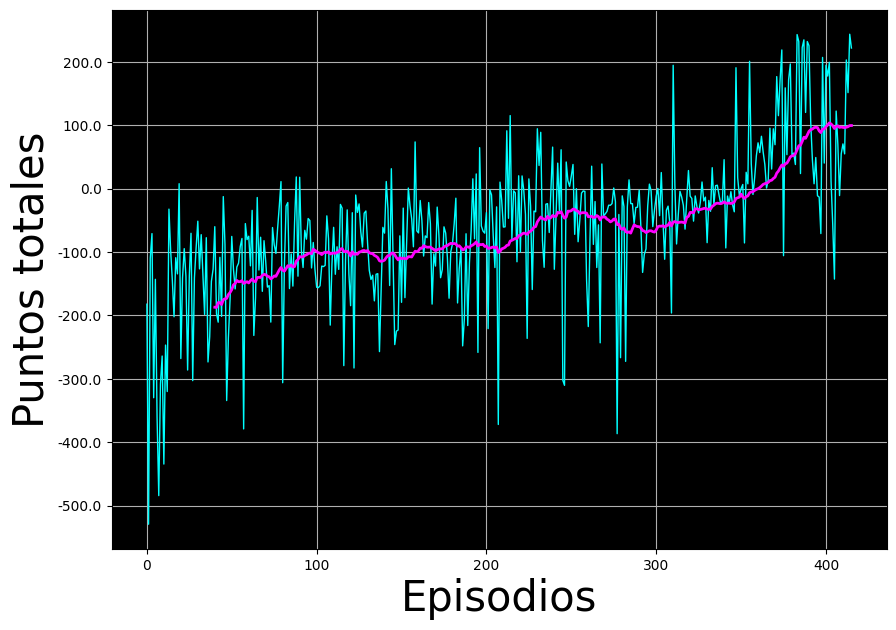

In [15]:
# Grafía el total de puntos
utils.plot_history(total_point_history)

In [16]:
# elimina errores imageio
import logging
logging.getLogger().setLevel(logging.ERROR)

En la celda siguiente creamos un video de nuestro agente interactuando con el entorno del Lunar Lander utilizando la q_network entrenada. El video se guarda en la carpeta de videos con el nombre de archivo proporcionado. Usamos la función utils.embed_mp4 para incrustar el video en Jupyter Notebook para que podamos verlo aquí directamente sin tener que descargarlo.

Debemos tener en cuenta que dado que el módulo de aterrizaje lunar comienza con una fuerza inicial aleatoria aplicada a su centro de masa, cada vez que ejecute la celda a continuación verá un video diferente. Si el agente fue entrenado adecuadamente, debería poder hacer aterrizar el módulo de aterrizaje lunar en la plataforma de aterrizaje cada vez, independientemente de la fuerza inicial aplicada a su centro de masa.

In [17]:
filename = "./videos/lunar_lander50.mp4"

utils.create_video(filename, env, q_network)
utils.embed_mp4(filename)